In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
# from imblearn.over_sampling import SMOTE

pd.set_option('display.float_format', '{:.3f}'.format)

In [2]:
df = pd.read_csv('/kaggle/input/expresso-churn-prediction-challenge/Train.csv')

# Data understanding

In [3]:
df.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.000,15.000,4251.000,1417.000,17.000,4.000,388.000,46.000,1.000,1.000,2.000,NO,54,On net 200F=Unlimited _call24H,8.000,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.000,2.000,1020.000,340.000,2.000,NaN,90.000,46.000,7.000,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.000,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.000,15.000,13502.000,4501.000,18.000,43804.000,41.000,102.000,2.000,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.000,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.000,1.000,985.000,328.000,1.000,NaN,39.000,24.000,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.000,0


In [4]:
df.isna().sum()

user_id                 0
REGION             849299
TENURE                  0
MONTANT            756739
FREQUENCE_RECH     756739
REVENUE            726048
ARPU_SEGMENT       726048
FREQUENCE          726048
DATA_VOLUME       1060433
ON_NET             786675
ORANGE             895248
TIGO              1290016
ZONE1             1984327
ZONE2             2017224
MRG                     0
REGULARITY              0
TOP_PACK           902594
FREQ_TOP_PACK      902594
CHURN                   0
dtype: int64

In [5]:
df.describe()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,CHURN
count,1397309.000,1397309.000,1428000.000,1428000.000,1428000.000,1093615.000,1367373.000,1258800.000,864032.000,169721.000,136824.000,2154048.000,1251454.000,2154048.000
mean,5532.117,11.529,5510.810,1836.943,13.978,3366.450,277.689,95.419,23.109,8.170,7.553,28.043,9.272,0.188
std,7111.339,13.274,7187.113,2395.700,14.694,13304.464,872.689,204.987,63.578,41.170,33.487,22.287,12.280,0.390
min,10.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000
25%,1000.000,2.000,1000.000,333.000,3.000,0.000,5.000,7.000,2.000,0.000,0.000,6.000,2.000,0.000
50%,3000.000,7.000,3000.000,1000.000,9.000,257.000,27.000,29.000,6.000,1.000,2.000,24.000,5.000,0.000
75%,7350.000,16.000,7368.000,2456.000,20.000,2895.000,156.000,99.000,20.000,3.000,5.000,51.000,12.000,0.000
max,470000.000,133.000,532177.000,177392.000,91.000,1823866.000,50809.000,21323.000,4174.000,4792.000,3697.000,62.000,713.000,1.000


# Drop những người inactive từ lâu

In [6]:
# =============================================================================
# 3. DROP INACTIVE CHURN
# =============================================================================
usage_cols = ["MONTANT", "REVENUE", "ON_NET", "ORANGE", "TIGO", "ZONE1", "ZONE2"]
usage_sum = df[usage_cols].fillna(0).sum(axis=1)

inactive_mask = (usage_sum == 0) & (df["CHURN"] == 1)
print("Inactive churn dropped:", inactive_mask.sum())

df = df[~inactive_mask].copy()
print("Shape after cleaning:", df.shape)


# =============================================================================
# 4. DROP USELESS COLUMNS
# =============================================================================
drop_cols = [c for c in ["ARPU_SEGMENT", "MRG", "user_id"] if c in df.columns]
df = df.drop(columns=drop_cols)
print("Shape after drop useless:", df.shape)


# =============================================================================
# 5. HANDLE MISSING VALUES
# =============================================================================
df["REGION"] = df["REGION"].fillna("unknown")

extra_numeric_cols = ["FREQUENCE_RECH", "FREQUENCE", "DATA_VOLUME", "FREQ_TOP_PACK"]
for col in usage_cols + extra_numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

Inactive churn dropped: 299279
Shape after cleaning: (1854769, 19)
Shape after drop useless: (1854769, 16)


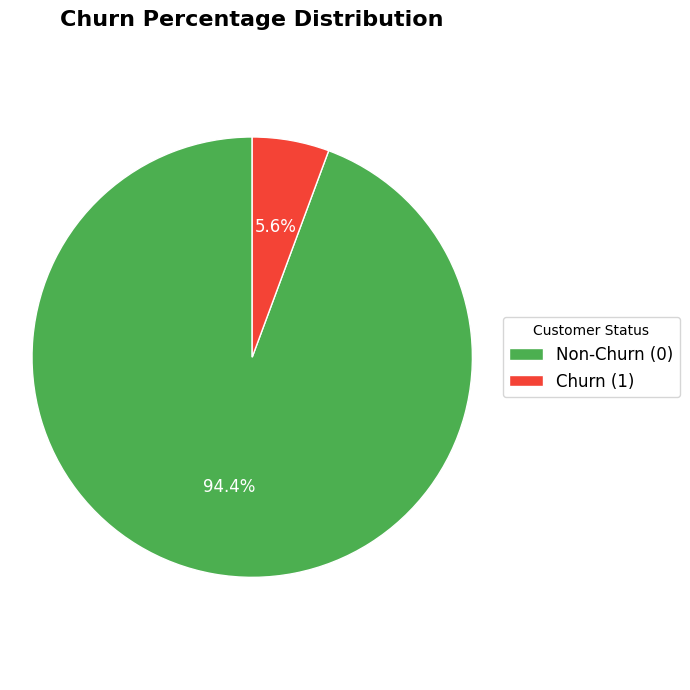

In [7]:
# Calculate %
churn_percent = df['CHURN'].value_counts(normalize=True) * 100

# Colors for better visual contrast
colors = ['#4CAF50', '#F44336']  # green = non-churn, red = churn

plt.figure(figsize=(7,7))

# Draw pie chart
wedges, texts, autotexts = plt.pie(
    churn_percent,
    labels=None,   # keep chart clean, labels will go to legend
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    textprops={'fontsize': 12, 'color': 'white'}
)

# Title
plt.title('Churn Percentage Distribution', fontsize=16, fontweight='bold')

# Legend on the right side
plt.legend(
    wedges,
    ['Non-Churn (0)', 'Churn (1)'],
    title="Customer Status",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=12
)

# Keep the chart circular
plt.axis('equal')

plt.tight_layout()
plt.show()

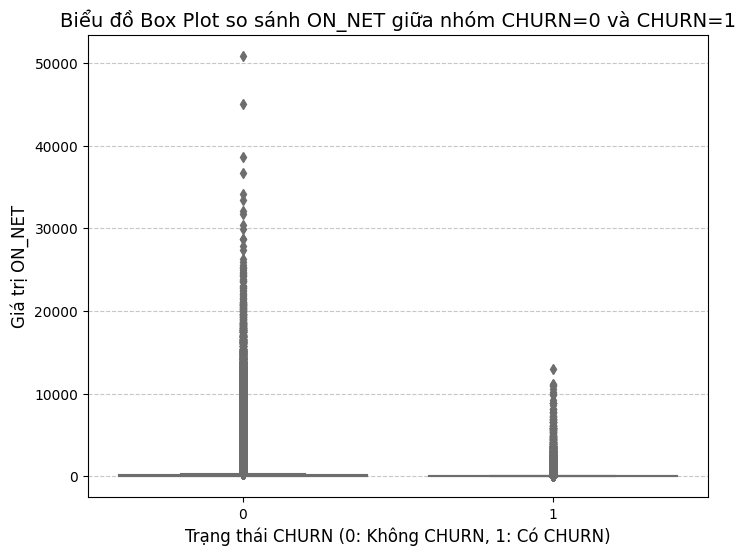

In [8]:
plt.figure(figsize=(8, 6))

sns.boxplot(
    x='CHURN',
    y='ON_NET',
    data=df,
    palette=['skyblue', 'salmon'] # Đổi màu cho dễ nhìn
)

# ----------------------------------------------------------------------
# BƯỚC 3: Thêm tiêu đề và nhãn cho biểu đồ
plt.title('Biểu đồ Box Plot so sánh ON_NET giữa nhóm CHURN=0 và CHURN=1', fontsize=14)
plt.xlabel('Trạng thái CHURN (0: Không CHURN, 1: Có CHURN)', fontsize=12)
plt.ylabel('Giá trị ON_NET', fontsize=12)

# Thêm lưới (grid) để dễ đọc
plt.grid(axis='y', linestyle='--', alpha=0.7)

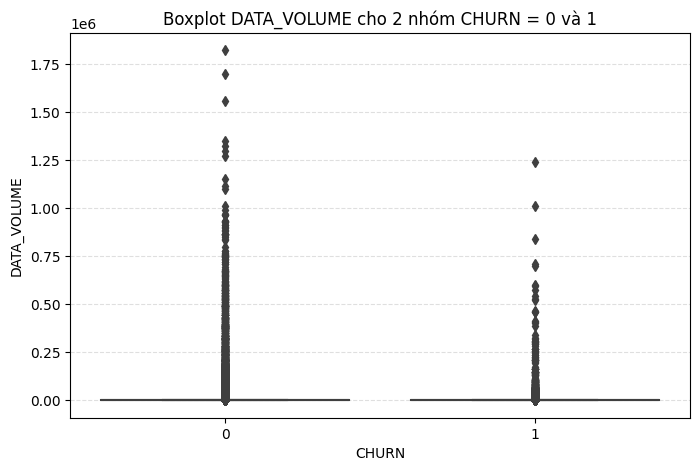

In [9]:
plt.figure(figsize=(8, 5))

sns.boxplot(x='CHURN', y='DATA_VOLUME', data=df)

plt.title('Boxplot DATA_VOLUME cho 2 nhóm CHURN = 0 và 1')
plt.xlabel('CHURN')
plt.ylabel('DATA_VOLUME')
plt.grid(True, axis='y', linestyle='--', alpha=0.4)

plt.show()

In [10]:
# BƯỚC 2: Định nghĩa "DATA VOLUME cao" và Lọc dữ liệu
# Cột cần lọc
CHURN_COL = 'CHURN'
DATA_VOLUME_COL = 'DATA_VOLUME'
REGION_COL = 'REGION'

# 2a. Lọc nhóm đã rời đi (CHURN = 1)
df_churn_1 = df[df[CHURN_COL] == 1].copy()

# 2b. Định nghĩa ngưỡng "DATA VOLUME cao"
# Dựa trên Boxplot, phần lớn dữ liệu gần bằng 0. Ta sẽ dùng Phân vị thứ 75 (75th Percentile)
# của nhóm CHURN = 1 làm ngưỡng để xác định "DATA VOLUME cao".
# Điều này giúp tập trung vào nhóm người dùng nặng trong số khách hàng rời đi.
high_volume_threshold = df_churn_1[DATA_VOLUME_COL].quantile(0.75)

print(f"Ngưỡng DATA VOLUME cao (75th Percentile của nhóm CHURN=1) là: {high_volume_threshold:.2f}")

# 2c. Lọc nhóm có DATA VOLUME cao
df_high_volume_churn = df_churn_1[df_churn_1[DATA_VOLUME_COL] >= high_volume_threshold].copy()
# ----------------------------------------------------------------------

# ----------------------------------------------------------------------
# BƯỚC 3: Tính toán tỉ lệ REGION 'unknown'
# Định nghĩa giá trị 'unknown' (có thể là 'UNKNOWN', 'Unknown', 'N/A', v.v. - tôi sẽ giả định là 'unknown' hoặc 'Unknown')
# Ta sẽ chuyển sang chữ thường để so sánh
unknown_count = df_high_volume_churn[REGION_COL].astype(str).str.lower().str.contains('unknown|n/a|na|none').sum()
total_count = len(df_high_volume_churn)

if total_count > 0:
    proportion = unknown_count / total_count
    
    print("\n--- Kết quả Phân tích ---")
    print(f"Tổng số khách hàng rời đi có DATA VOLUME cao: {total_count}")
    print(f"Số khách hàng có REGION là 'unknown' trong nhóm này: {unknown_count}")
    print(f"Tỉ lệ REGION 'unknown': {proportion:.2%} ({unknown_count}/{total_count})")
    
else:
    print("\nKhông tìm thấy khách hàng rời đi có DATA VOLUME cao theo ngưỡng 75th Percentile.")
# ----------------------------------------------------------------------

Ngưỡng DATA VOLUME cao (75th Percentile của nhóm CHURN=1) là: 438.00

--- Kết quả Phân tích ---
Tổng số khách hàng rời đi có DATA VOLUME cao: 26194
Số khách hàng có REGION là 'unknown' trong nhóm này: 23780
Tỉ lệ REGION 'unknown': 90.78% (23780/26194)


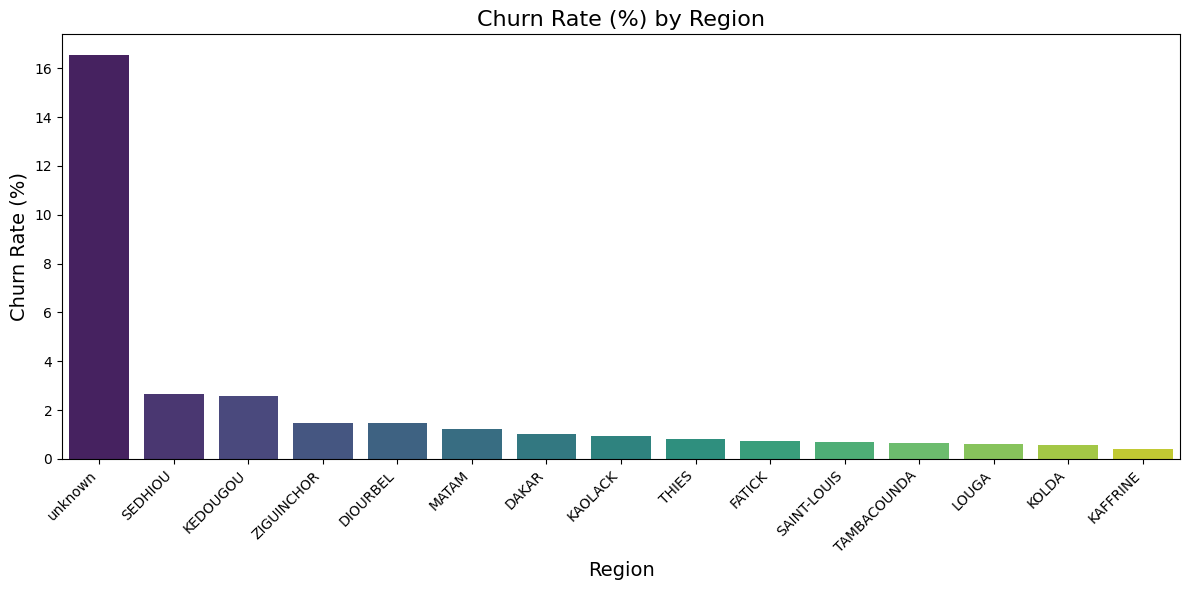

In [11]:
# Calculate Churn Rate by REGION
churn_rate_by_region = df.groupby('REGION')['CHURN'].mean().mul(100).reset_index()
churn_rate_by_region.columns = ['REGION', 'Churn_Rate (%)']

plt.figure(figsize=(12, 6))
sns.barplot(x='REGION', y='Churn_Rate (%)', data=churn_rate_by_region.sort_values(by='Churn_Rate (%)', ascending=False), palette='viridis')
plt.title('Churn Rate (%) by Region', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('Churn Rate (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

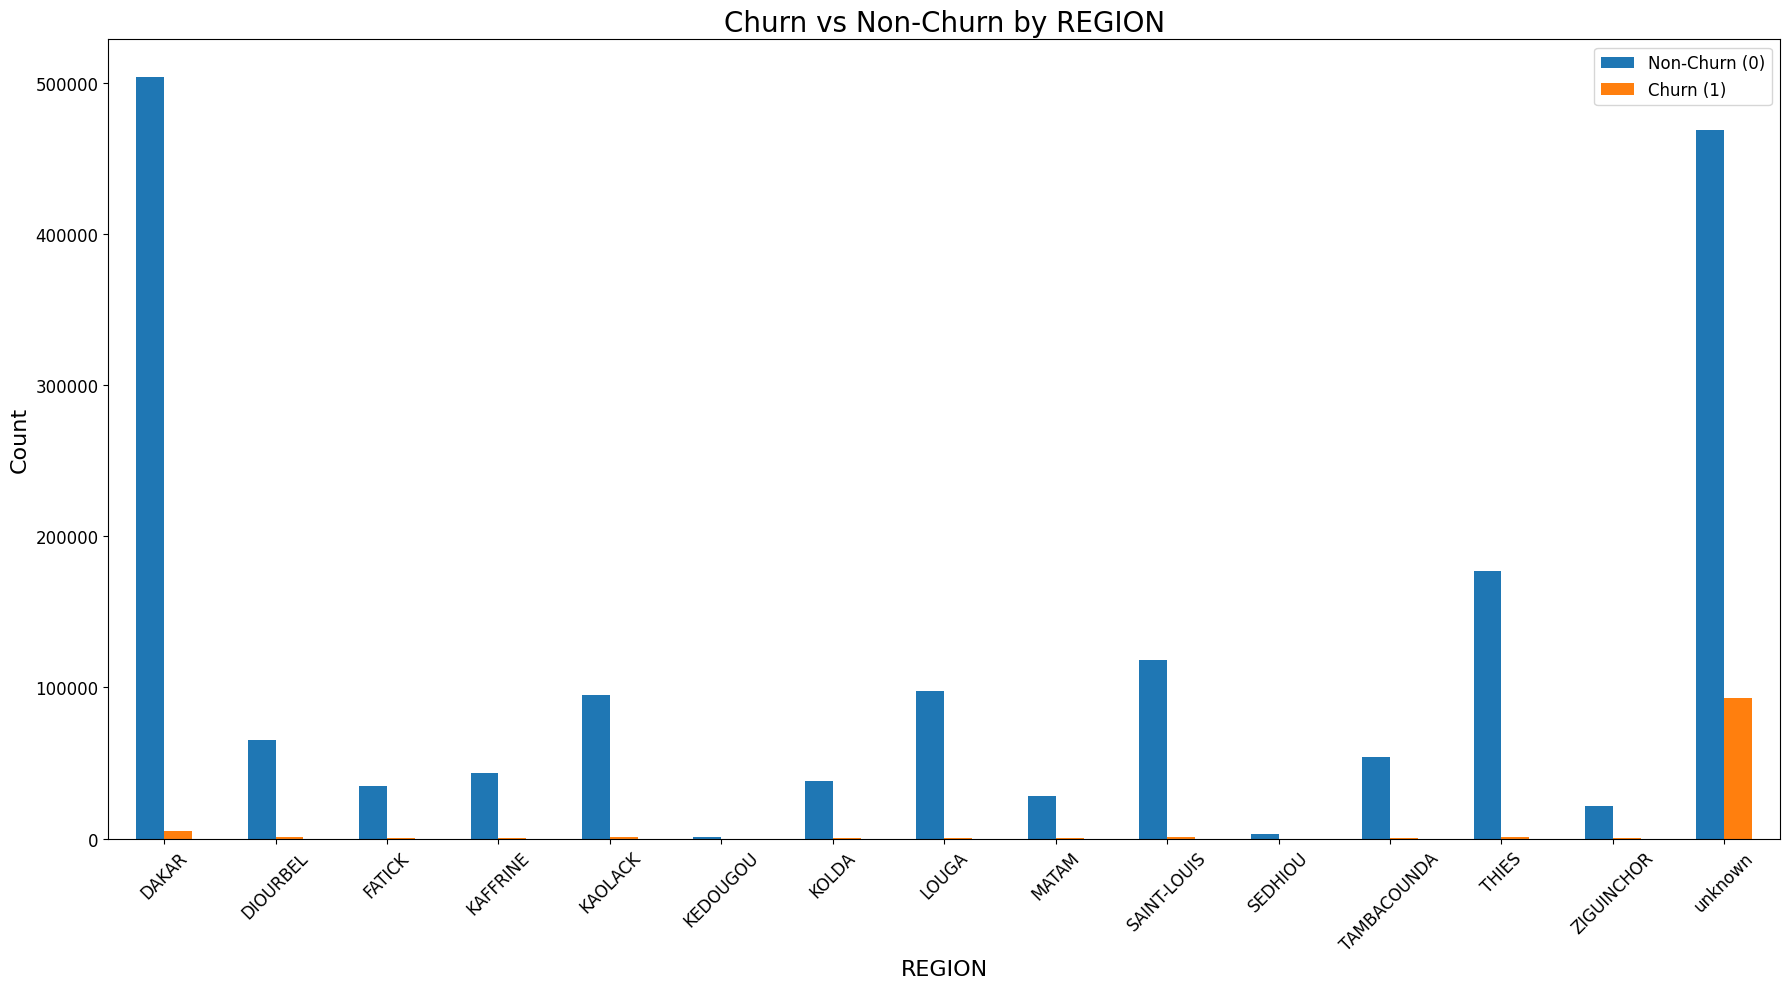

In [12]:
# ====== 1. Lấy top N gói phổ biến nhất ======
# Danh sách các cột phân loại cần điền 'Unknown'
categorical_cols = ['REGION']

for col in categorical_cols:
    df[col] = df[col].fillna('unknown')
top_n = 20
top_packs = df['REGION'].value_counts().head(top_n).index

# Lọc dataset chỉ giữ các TOP_PACK này
df_top = df[df['REGION'].isin(top_packs)]

# ====== 2. Tạo bảng churn - non churn theo TOP_PACK ======
grouped = df_top.groupby(['REGION', 'CHURN']).size().unstack(fill_value=0)

# ====== 3. Vẽ biểu đồ ======
ax = grouped.plot(kind='bar', figsize=(18, 10))

plt.title(f'Churn vs Non-Churn by REGION', fontsize=20)
plt.xlabel('REGION', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Non-Churn (0)', 'Churn (1)'], fontsize=12)
plt.tight_layout()
plt.show()

In [13]:
# 1. Xác định ngưỡng DATA_VOLUME cao (ví dụ 75th percentile)
threshold = df['DATA_VOLUME'].quantile(0.75)
high_data = df[df['DATA_VOLUME'] >= threshold]

# 2. Lọc nhóm CHURN = 1
high_data_churn = high_data[high_data['CHURN'] == 1]

# 3. Tính % REGION = 'unknown'
unknown_count = (high_data_churn['REGION'] == 'unknown').sum()
total_count = high_data_churn.shape[0]
unknown_percent = (unknown_count / total_count) * 100
print(f"Tỷ lệ REGION = 'unknown' trong nhóm DATA_VOLUME cao & CHURN=1: {unknown_percent:.2f}%")

# 4. Vẽ Pie chart phân bố REGION trong nhóm này
region_counts = high_data_churn['REGION'].value_counts().reset_index()
region_counts.columns = ['REGION', 'count']

fig = px.pie(region_counts, values='count', names='REGION',
             color_discrete_sequence=px.colors.sequential.Viridis)

fig.show()

Tỷ lệ REGION = 'unknown' trong nhóm DATA_VOLUME cao & CHURN=1: 90.92%


In [14]:
# 1. Histogram REGULARITY
fig_hist = px.histogram(
    high_data_churn,
    x='REGULARITY',
    nbins=20,  # số cột histogram
    title='Phân bố REGULARITY của nhóm DATA_VOLUME cao & CHURN=1',
    labels={'REGULARITY': 'REGULARITY'},
    color_discrete_sequence=['#636EFA']
)
fig_hist.show()

# 2. Box plot REGULARITY
fig_box = px.box(
    high_data_churn,
    y='REGULARITY',
    title='Box plot REGULARITY của nhóm DATA_VOLUME cao & CHURN=1',
    labels={'REGULARITY': 'REGULARITY'},
    color_discrete_sequence=['#EF553B']
)
fig_box.show()

# 3. Nếu muốn, có thể kết hợp histogram và color theo REGION
fig_hist_region = px.histogram(
    high_data_churn,
    x='REGULARITY',
    nbins=60,
    color='REGION',
    title='Phân bố REGULARITY theo REGION trong nhóm DATA_VOLUME cao & CHURN=1',
    labels={'REGULARITY': 'REGULARITY'},
    barmode='overlay',  # chồng các màu theo REGION
    opacity=0.7
)
fig_hist_region.show()

In [15]:
# 1. Xác định ngưỡng DATA_VOLUME cao (phân vị 0.75)
# Sử dụng method .quantile(0.75) trên cột 'DATA_VOLUME' của DataFrame gốc (df)
quantile_75 = df['DATA_VOLUME'].quantile(0.75)

# 2. Lọc DataFrame
# Lọc đồng thời 2 điều kiện:
#   A. 'DATA_VOLUME' lớn hơn hoặc bằng ngưỡng 0.75
#   B. 'CHURN' bằng 1
df_high_data_churn = df[
    (df['DATA_VOLUME'] >= quantile_75) & 
    (df['CHURN'] == 1)
]

# 3. Hiển thị thông tin cơ bản của nhóm được lọc để kiểm tra
print(f"Ngưỡng DATA_VOLUME (Q75) là: {quantile_75:.2f}")
print(f"Số lượng khách hàng trong nhóm DATA_VOLUME cao & CHURN=1 là: {len(df_high_data_churn)}")

Ngưỡng DATA_VOLUME (Q75) là: 678.00
Số lượng khách hàng trong nhóm DATA_VOLUME cao & CHURN=1 là: 23285


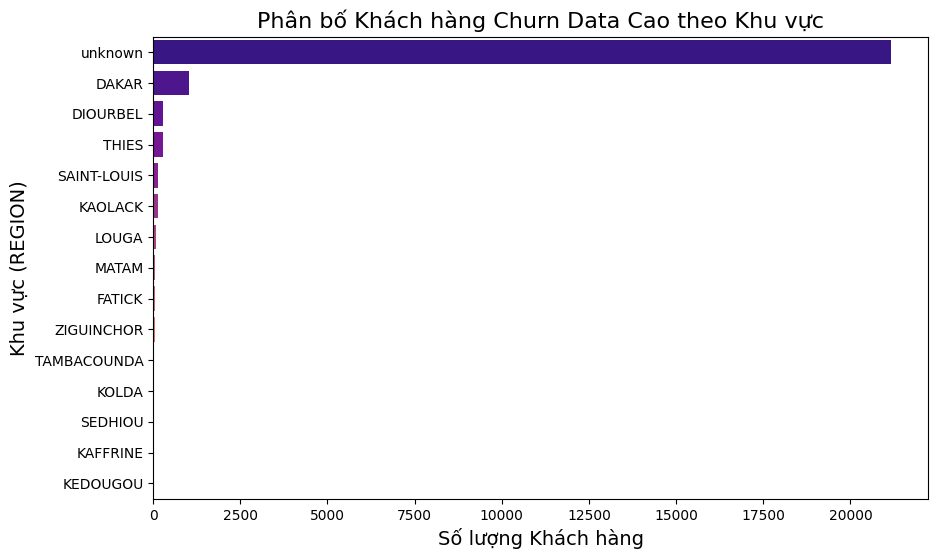

In [16]:
plt.figure(figsize=(10, 6))
# Đếm số lượng khách hàng churn theo REGION
sns.countplot(y='REGION', 
              data=df_high_data_churn, 
              order=df_high_data_churn['REGION'].value_counts().index, 
              palette='plasma')
plt.title('Phân bố Khách hàng Churn Data Cao theo Khu vực', fontsize=16)
plt.xlabel('Số lượng Khách hàng', fontsize=14)
plt.ylabel('Khu vực (REGION)', fontsize=14)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



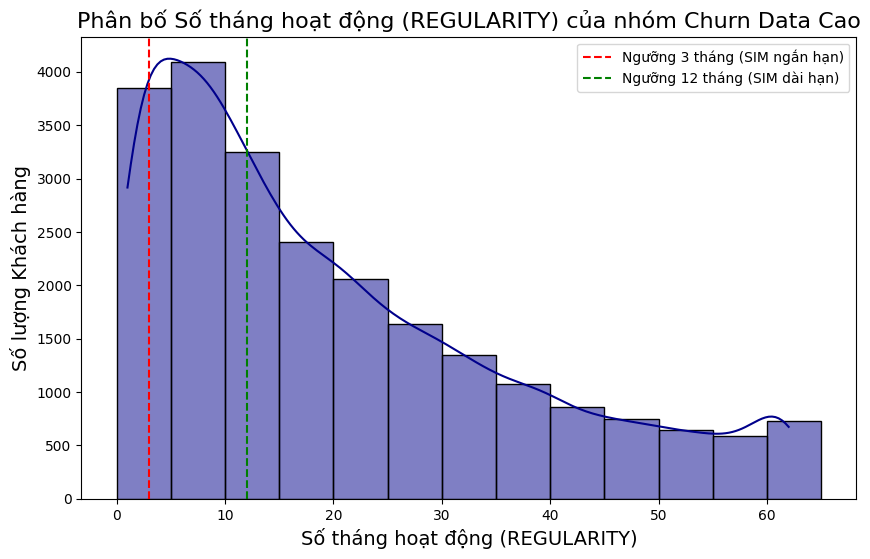

In [17]:
plt.figure(figsize=(10, 6))
# Vẽ biểu đồ Histogram cho REGULARITY
sns.histplot(df_high_data_churn['REGULARITY'], 
             bins=range(0, int(df_high_data_churn['REGULARITY'].max()) + 5, 5), # Chia bin 5 tháng 1 lần
             kde=True, # Ước tính mật độ phân bố
             color='darkblue')

plt.axvline(x=3, color='red', linestyle='--', label='Ngưỡng 3 tháng (SIM ngắn hạn)')
plt.axvline(x=12, color='green', linestyle='--', label='Ngưỡng 12 tháng (SIM dài hạn)')
plt.title('Phân bố Số tháng hoạt động (REGULARITY) của nhóm Churn Data Cao', fontsize=16)
plt.xlabel('Số tháng hoạt động (REGULARITY)', fontsize=14)
plt.ylabel('Số lượng Khách hàng', fontsize=14)
plt.legend()
plt.show()

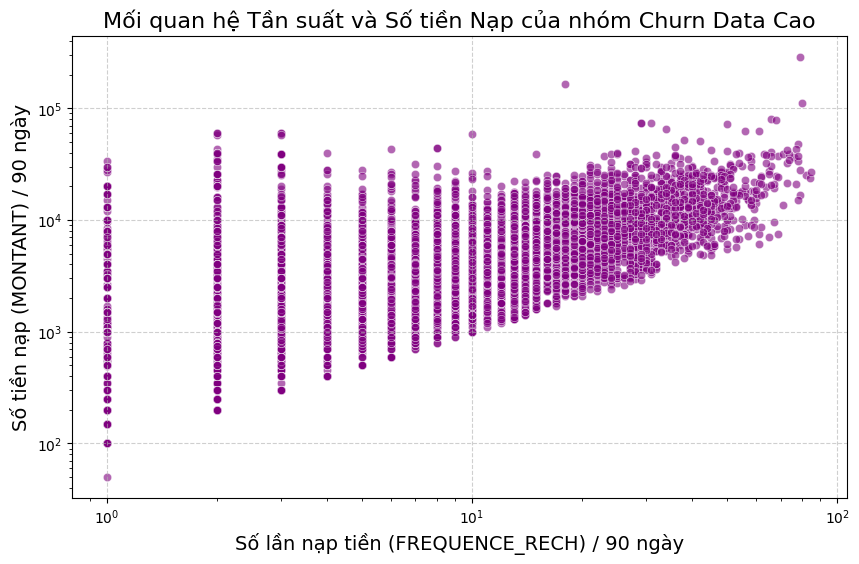

In [18]:
plt.figure(figsize=(10, 6))
# Biểu đồ tán xạ giữa Số lần nạp tiền và Số tiền nạp
sns.scatterplot(x='FREQUENCE_RECH', 
                y='MONTANT', 
                data=df_high_data_churn, 
                alpha=0.6, # Độ trong suốt
                color='purple')

plt.title('Mối quan hệ Tần suất và Số tiền Nạp của nhóm Churn Data Cao', fontsize=16)
plt.xlabel('Số lần nạp tiền (FREQUENCE_RECH) / 90 ngày', fontsize=14)
plt.ylabel('Số tiền nạp (MONTANT) / 90 ngày', fontsize=14)
plt.xscale('log') # Sử dụng log scale để dễ nhìn hơn do có thể có giá trị ngoại lệ
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

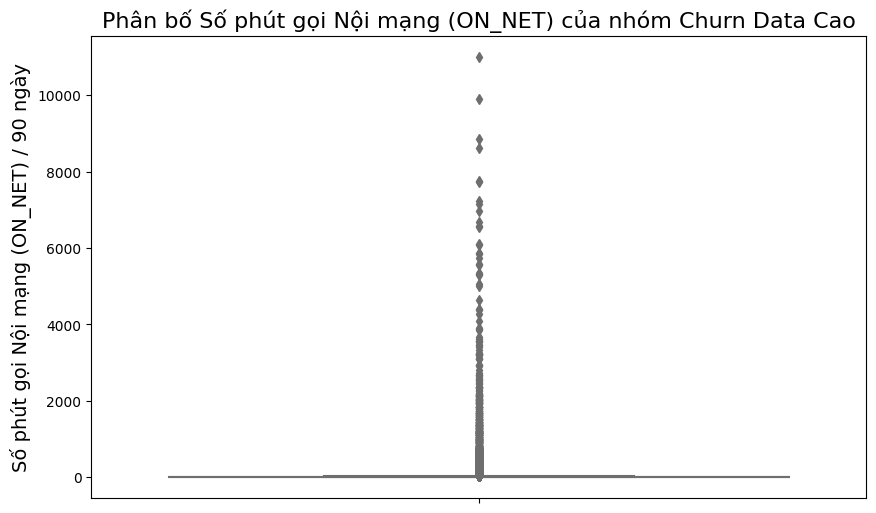


Thống kê ON_NET (Số phút gọi Nội mạng):
count   23285.000
mean       50.588
std       306.997
min         0.000
25%         0.000
50%         3.000
75%        10.000
max     10994.000
Name: ON_NET, dtype: float64


In [19]:
plt.figure(figsize=(10, 6))
# Vẽ biểu đồ hộp (Box Plot) để xem phân bố ON_NET
sns.boxplot(y='ON_NET', data=df_high_data_churn, color='lightcoral')

plt.title('Phân bố Số phút gọi Nội mạng (ON_NET) của nhóm Churn Data Cao', fontsize=16)
plt.ylabel('Số phút gọi Nội mạng (ON_NET) / 90 ngày', fontsize=14)
plt.show()

# In ra các giá trị thống kê cơ bản
print("\nThống kê ON_NET (Số phút gọi Nội mạng):")
print(df_high_data_churn['ON_NET'].describe())

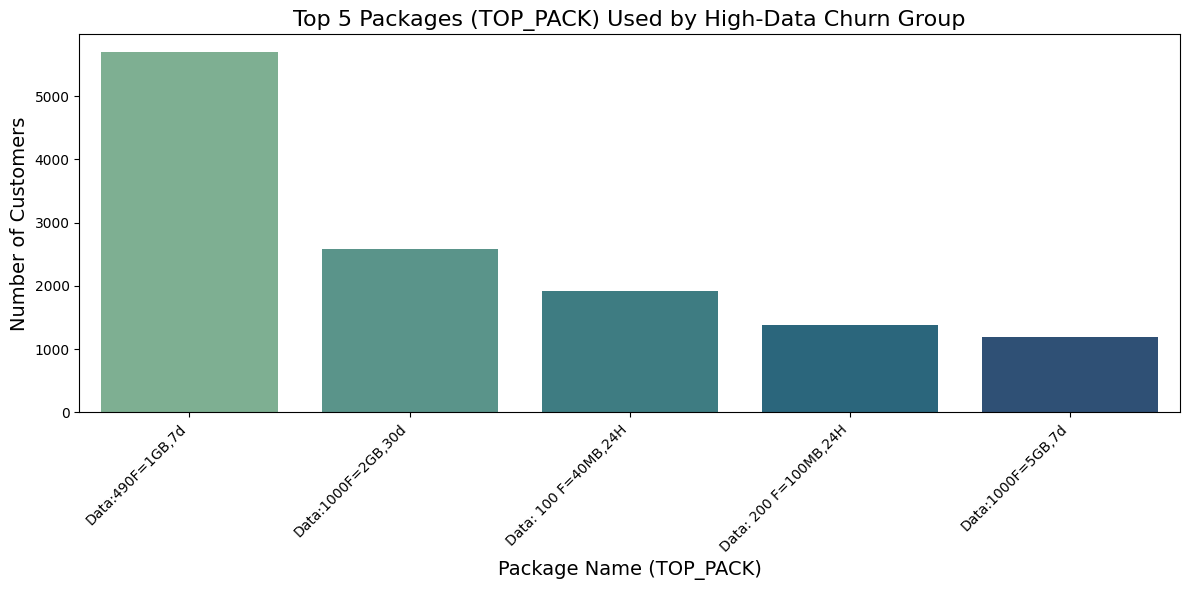

In [20]:
plt.figure(figsize=(12, 6))

# Count the top 10 packages
top_packs_churn = df_high_data_churn['TOP_PACK'].value_counts().nlargest(5)

sns.barplot(x=top_packs_churn.index, 
            y=top_packs_churn.values, 
            palette='crest')

# Translated labels
plt.title('Top 5 Packages (TOP_PACK) Used by High-Data Churn Group', fontsize=16)
plt.xlabel('Package Name (TOP_PACK)', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Số lượng khách hàng Churn Data Cao ở REGION 'unknown' là: 21171
REGULARITY trung bình của nhóm này là: 20.32 tháng
REGULARITY tối đa của nhóm này là: 62 tháng


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



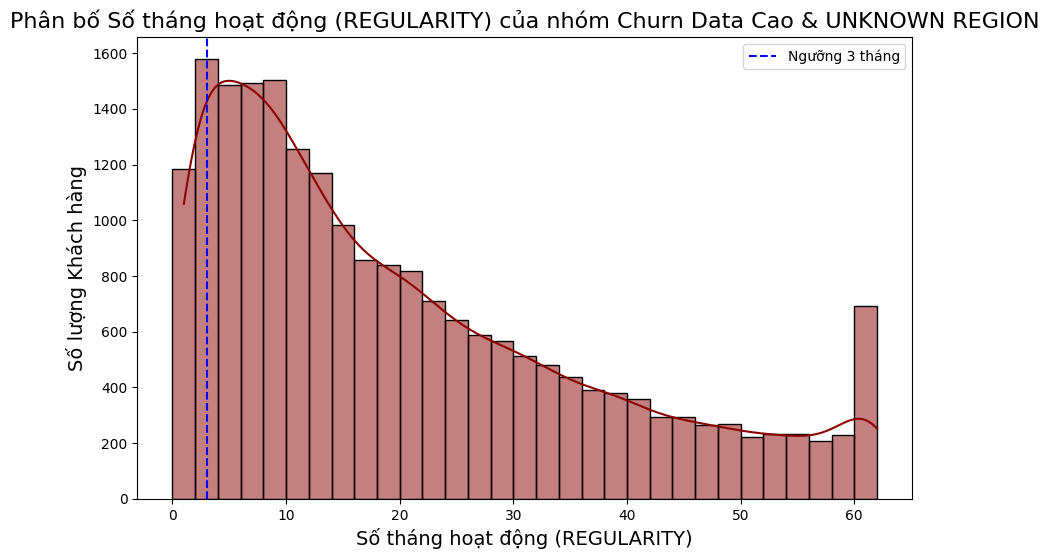

In [21]:
# 1. Lọc DataFrame cho nhóm UNKNOWN REGION
df_unknown_region = df_high_data_churn[df_high_data_churn['REGION'] == 'unknown']

# 2. In ra thông tin cơ bản để kiểm tra
print(f"Số lượng khách hàng Churn Data Cao ở REGION 'unknown' là: {len(df_unknown_region)}")
print(f"REGULARITY trung bình của nhóm này là: {df_unknown_region['REGULARITY'].mean():.2f} tháng")
print(f"REGULARITY tối đa của nhóm này là: {df_unknown_region['REGULARITY'].max()} tháng")

# 3. Vẽ biểu đồ Phân bố REGULARITY
plt.figure(figsize=(10, 6))

# Lấy giá trị max cho việc chia bins
max_reg = df_unknown_region['REGULARITY'].max()
bins_range = np.arange(0, max_reg + 2, 2) # Chia bin 2 tháng 1 lần

sns.histplot(df_unknown_region['REGULARITY'], 
             bins=bins_range,
             kde=True,
             color='darkred')

plt.axvline(x=3, color='blue', linestyle='--', label='Ngưỡng 3 tháng')

plt.title('Phân bố Số tháng hoạt động (REGULARITY) của nhóm Churn Data Cao & UNKNOWN REGION', fontsize=16)
plt.xlabel('Số tháng hoạt động (REGULARITY)', fontsize=14)
plt.ylabel('Số lượng Khách hàng', fontsize=14)
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



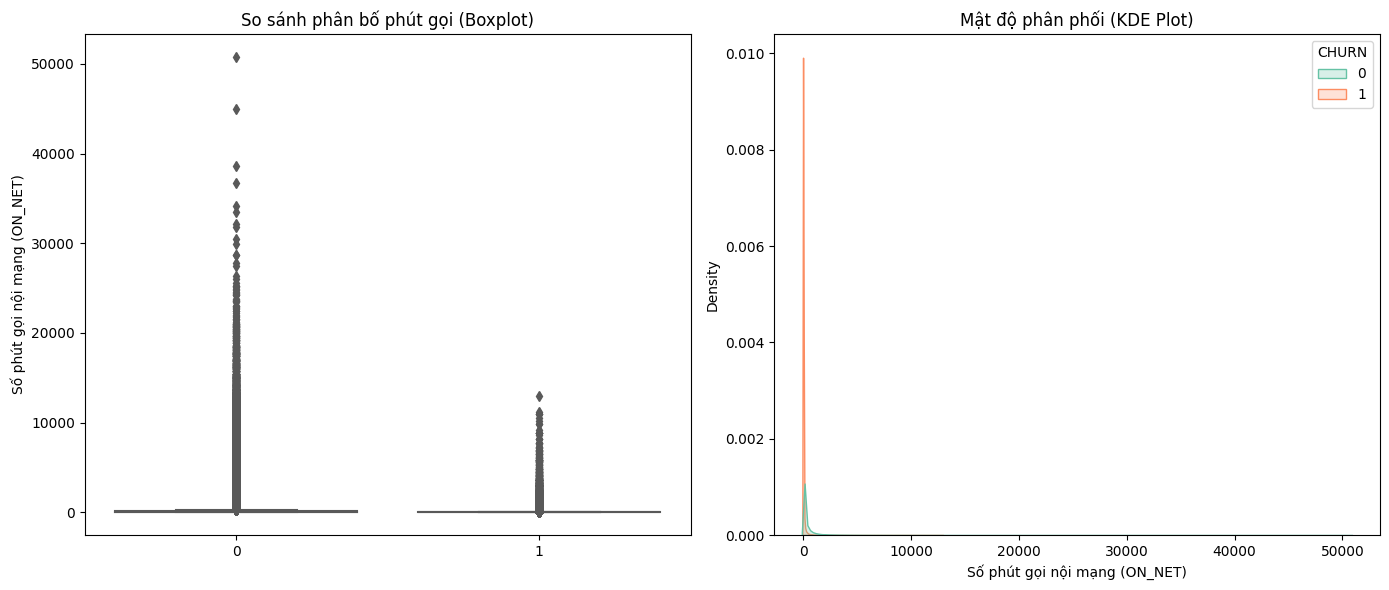

In [22]:
# --- PHẦN 2: VẼ BIỂU ĐỒ ---
# Thiết lập kích thước
plt.figure(figsize=(14, 6))

# Biểu đồ 1: Boxplot (Biểu đồ hộp)
# Giúp nhìn rõ giá trị trung vị, tứ phân vị và các giá trị ngoại lai (outliers)
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='CHURN', y='ON_NET', palette="Set2")
plt.title('So sánh phân bố phút gọi (Boxplot)')
plt.ylabel('Số phút gọi nội mạng (ON_NET)')
plt.xlabel('')

# Biểu đồ 2: KDE Plot (Biểu đồ mật độ)
# Giúp nhìn thấy vùng trùng lặp giữa hai nhóm khách hàng
plt.subplot(1, 2, 2)
sns.kdeplot(data=df, x='ON_NET', hue='CHURN', fill=True, common_norm=False, palette="Set2")
plt.title('Mật độ phân phối (KDE Plot)')
plt.xlabel('Số phút gọi nội mạng (ON_NET)')

plt.tight_layout()
plt.show()